# 2024 SCOPED Workshop — Wavefield Simulations Using SPECFEM

## Notebook 1: Intro to SPECFEM2D

- This short notebook is meant to introduce new Users to SPECFEM by teaching them how to:
    1) navigate a SPECFEM2D working directory
    2) generate a 2D mesh with homogeneous halfspace model
    3) run a forward simulation to generate synthetic seismograms   
- **Objective**: Understand `SPECFEM2D` and draw parallels to `SPECFEM3D` 
- These instructions should be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 
- This Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2024-5-21_scoped_uw/1_intro_specfem2d.ipynb
- SPECFEM2D GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


----------
## 1) SPECFEM2D Directory Tour

- Let's start by touring around the SPECFEM2D repository, which is located in `/home/scoped/specfem2d`  
- **Note**: This directory is not the same as what you would clone from GitHub, we have removed a number of files to keep container size reasonable  
- The `devel` branch of all SPECFEM (2D/3D/3D_GLOBE) versions contains the most up to date codebase

In [ ]:
# Python packages we will use on our tour
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
from seisflows.tools.model import Model

# Make sure we're in the correct directory
%cd /home/scoped/specfem2d
! ls

### 1a) SPECFEM Executables in *bin/* directory

- We have already downloaded (*git clone*), configured (*./configure*) and compiled (*make all*) SPECFEM2D   
- Executables (computer instruction sets) created by the compilation step are located in the `bin/` directory  
- Each of these executables performs a different function in the package

In [ ]:
# Let's have a look at the executables
! ls bin

The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D`: generate a numerical mesh, the skeleton of the domain upon which we run our numerical simulations   
- `xspecfem2D`: run the spectral element solver, generates synthetic seismograms for a given source and set of stations  

Some other important executables we will use in Days 2 and 3:
- `xsmooth_sem`: smoothing through convolution with a 2D Gaussian. Users define horizontal and vertical half-widths of the Gaussian  
- `xcombine_sem`: sums multiple volumetric quantities, used e.g., to sum multiple kernels together  

You can often run an executable to determine it's usage requirements:

In [ ]:
! mpirun -n 1 bin/xcombine_sem

**NOTE**: The above code snippet will return *'Error detected, aborting MPI'...*. This is OK, and is expected when calling the executable with no arguments  

### 1b) Parameters and Simulation Data in *DATA/* directory

- *DATA/* directory contains external data and control parameters provided to SPECFEM
- The most important files are: `Par_file`, `SOURCE` and `STATIONS`
    - `Par_file`: Parameter file used to control simulation  
    - `SOURCE`: Defines source location and mechanism (e.g moment tensor, force). 
    - `STATIONS`: Defines station codes and locations (Cartesian or geographic). 


>__SOURCE NOTE__: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  
>__STATIONS NOTE__: In SPECFEM2D, station information may also be defined in the `Par_file`

In [ ]:
def print_pretty(text):
    """Makes it easier to distinguish print statement outputs"""
    print(f"\n{'='*80}\n {text:^80}\n{'='*80}\n")

# Look at the DATA/ directory
print_pretty("DATA/ DIRECTORY")
! ls DATA/

# Illustrates that the Par_file is an ASCII file with key-value pairs
print_pretty("PARAMETER FILE (Par_file)")
! head -38 DATA/Par_file

# The SPECFEM2D SOURCE file defines a 2D seismic source
print_pretty("SOURCE FILE (SOURCE)")
! head DATA/SOURCE
! echo "..."
! tail DATA/SOURCE

# Sometimes in SPECFEM2D, the Par_file defines station information directly
print_pretty("INTERNAL STATION DEFINITION (Par_file)")
! head -189 DATA/Par_file | tail -n 7

# However, other examples may define station information using STATIONS files, which is formatted:
print_pretty("EXTERNAL STATION DEFINITION (STATIONS)")
print("# STATION NETWORK X[m] Z[m] burial[m] elevation[m]")
! head -5 EXAMPLES/Tape2007/DATA/STATIONS_checker

### 1c) Results stored in *OUTPUT_FILES/* directory

- Outputs generated by SPECFEM are stored in the `OUTPUT_FILES/` directory  
- Outputs include: log files, error messages, synthetic seismograms, figures, database files  
- Database files store information about the mesh and model  
- **SPECFEM3D NOTE:** SPECFEM3D maintains a separate database directory (typically called `DATABASES_MPI/`).

In [ ]:
# Contains the error message from the previous command
! ls OUTPUT_FILES

-----------
## 2) Running the Mesher (`xmeshfem2D`)  

- We will use two terms to talk about meshing:  
    - **MESH**: a numerical grid which defines coordinate points only (i.e., X and Z in 2D).  
    - **MODEL**: parameter values (e.g., seismic velocity) approximating structure, assigned to locations on the MESH.  
- The **first** thing we need to do when approaching numerical simulations is to generate a numerical mesh   
- During *this* workshop we will use SPECFEM's internal mesher, `Meshfem`. External programs exist, such as [Gmsh](https://gmsh.info/) and [Trelis](https://coreform.com/products/coreform-cubit/) 


### Mesh Examples
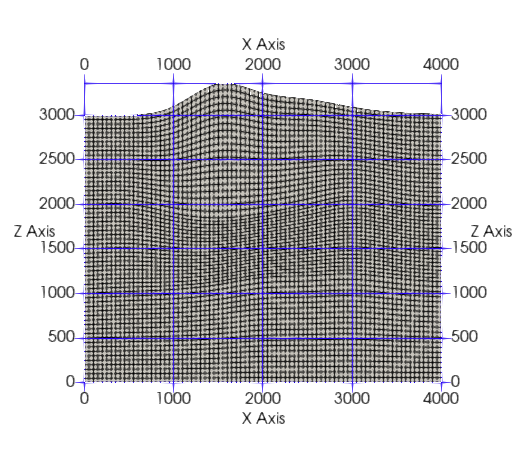
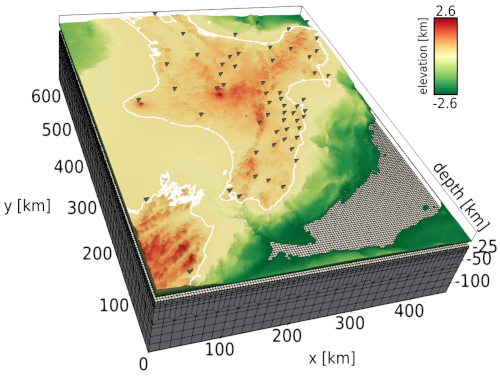


### 2a) Model Parameters

- In SPECFEM2D, *mesh* and *model* specifications are defined in the `Par_file`  
- There are a number of parameter options we can use to customize them
- In **SPECFEM3D**, mesh files are defined in a separate `Mesh_Par_file`, typically stored in `DATA/meshfem3D_files`.

In [ ]:
# Incase participants get lost, each numbered section 
# contains the absolute work dir path
%cd /home/scoped/specfem2d

# Look at the definition of the model in the Par_file
! head -298 DATA/Par_file | tail -n 28

- In the output above we can see that our `Par_file` defines 4 separate regions, each with varying values for density and velocity.

```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```
- These regions have **no** sense of space. They only represent material properties.
- These regions will be assigned to parts of the *mesh* in the following section

### 2b) Mesh Parameters

- The internal mesher has a set of parameters that allows Users to provide: interfaces, geometry, boundary conditions.
    - **Interfaces** define the contact point between two mesh domains. Across an interface, mesh geometry and model parameters can change.
    - **Boundary conditions** define how waves interact with the edges of your finite domain. Often absorbing boundary conditions are used.
    - **Mesh geometry** can be optimized to reduce computational cost while keeping simulations stable.

In [ ]:
! head -320 DATA/Par_file | tail -n 21

#### Understanding Internal Mesh Parameters
- In Meshfem2D we can set any of the 4 edges to be absoring
- The top boundary is often not absoring, to mimic surface reflections as you would have in the real world
- The section at the bottom partitions *materials* defined by the model, to *regions* of the mesh
- A separate *interface* file defines the shape of boundaries within the mesh

In [ ]:
# Let's have a look at the `interfaces` file which defines boundary interfaces 
! cat ./EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

#### Understanding Interface Files
- There are 4 interfaces defined in this file (bottom of mesh, 2 internal interfaces, top of mesh)  
- The bottom of the mesh is flat; the other 3 interfaces (including top of mesh, a.k.a topography) are curved  
- We define 20 elements in each layer for 60 total elements in the Z direction

### 2c) Setting Up Meshfem

- We need to set a few `Par_file` parameters to tell SPECFEM how to behave during meshing  
- Here, for convenience, we introduce the `SeisFlows` command line tool, which provides Python-based utility functions 
- We will use the `seisflows sempar` commmand line utility to print and edit values from the SPECFEM2D `Par_file`   

----------
**SEMPAR NOTE**: The `sempar` (spectral element method parameter) command syntax is as follows
```python
seisflows sempar -P <Par_file> <key> <value:optional>
```
- \<Par_file> is the path the SPECFEM `Par_file`
- \<key> represents a parameter in the par file (case-insensitive) 
- \<value> is an optional parameter to overwrite an existing parameter. 
--------------    

In [ ]:
! seisflows sempar -P DATA/Par_file model  # <- This is a print statement
! seisflows sempar -P DATA/Par_file nproc 4  # <- This is a change of variables  
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

#### Meshfem Parameter Explanations

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (this is the default option)  
`NPROC`: Number of MPI processes to run on. The mesh itself is partitioned into `NPROC` sections, each of which is provided to a separate processor  
`setup_with_binary_database`: Writes database files in FORTRAN Binary format, by default they are *not* saved  
`SAVE_MODEL`: Write the model out in FORTRAN Binary format. As opposed to other formats like ASCII

### 2d) Run Meshfem Executable

- SPECFEM will look for relevant data in the *DATA/* directory
- It will generate a numerical mesh in the *OUTPUT_FILES/* directory. 
- The *model* will **not** be output until we run the solver (`xspecfem2D`) later in the notebook

In [ ]:
# Run the mesher and re-direct output to a text file
! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt
! echo "..."
! tail OUTPUT_FILES/output_meshfem2d.txt

In [ ]:
# e.g., the mesher has created our STATIONS File
! head -255 OUTPUT_FILES/output_meshfem2d.txt | tail -n 34

In [ ]:
# The STATIONS file matches what the log file tells us 
! cat DATA/STATIONS

In [ ]:
# Database files are stored in the OUTPUT_FILES/ directory as FORTRAN binary (.bin) files
! ls OUTPUT_FILES/Database*.bin

In [ ]:
# SPECFEM also outputs Visualization Toolkit (.vtk) files which
# can be used for visualization using external software
! ls OUTPUT_FILES/*.vtk

---------
## 3) Running the Solver `xspecfem2D`

- The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a wave propagation simulation  
- `xspecfem2D` uses the provided `SOURCE` to initiate a force in the domain  
- The propagating wavefield is simulated across the **entire** domain  
- The `STATIONS` files tells SPECFEM where to **store** waveforms generated by the propagating wavefield
- These files are **synthetic seismograms** and mimic real-world recordings made by seismometers  

![wavefield gif](https://user-images.githubusercontent.com/23055374/193936208-6ec5fbe6-dfed-41f1-945e-ede9f737a0ea.gif)

*Example 3D wavefield simulation (wavefield shown at the surface) illustrating the wavefield being simulated throughout the domain, whereas stations define point recordings of the wavefield*

In [ ]:
%cd /home/scoped/specfem2d

# Let's look at some Solver-specific parameters
! head -171 DATA/Par_file | tail -n 32

### Some Important Solver Parameters

- `seismotype`: Set units of the output synthetic seismograms. Here we output 'displacement' in SI unit meters  
- `USER_T0`: Defines the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source  
- `save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files, as opposed to binary or Seismic Unix format    

In [ ]:
# Run the solver on 4 cores, re-direct output log
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Again, the log file contains important information on the process
! head OUTPUT_FILES/output_solver.txt
! echo "..."
! tail OUTPUT_FILES/output_solver.txt

In [ ]:
# Mesh and Model parameters are assigned here
! head -282 OUTPUT_FILES/output_solver.txt | tail -n 16

In [ ]:
# During the simulation, the log file updates the User on progress
! head -1053 OUTPUT_FILES/output_solver.txt | tail -n 32

In [ ]:
# The solver writes out model files at the end of the simulation
! tail -n 25 OUTPUT_FILES/output_solver.txt

-------------
## 4) Understanding SPECFEM2D Output Files

- `xspecfem2D` has created a number of output files
- These files include a log message, additional DATABASE files, synthetic seismograms, and the output model

In [ ]:
%cd /home/scoped/specfem2d

# For example, the DATA/*.bin files define our velocity model
! ls DATA/*bin

### 4a) Velocity Model

- `xspecfem2D` outputs the velocity model to the *DATA/* directory  
- We can use some SeisFlows utility functions to plot this model to help us visualize our domain  
- **SPECFEM3D NOTE**: SPECFEM3D outputs velocity model files to the `Par_file` parameter `LOCAL_PATH`, commonly `OUTPUT_FILES/DATABASES_MPI`

In [ ]:
def plot_velocity_model():
    """Convenience function to plot velocity model with sources and stations"""
    # Grab STATION coordinates by reading ACSII files
    sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T
    sta_id = np.genfromtxt("DATA/STATIONS", dtype=str, usecols=[0]).T

    # Grab SOURCE coordinates from SOURCE file
    source_file = f"DATA/SOURCE"
    with open(source_file, "r") as f:
        lines = f.readlines()

    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
    ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

    # Use SeisFlows 'Model' class to plot the 2D model 
    m = Model(path="DATA")
    m.plot2d(parameter="vs", show=False)

    # Plot SOURCE and STATIONS on top of the model
    for x_, z_, id_ in zip(sta_x, sta_z, sta_id):
        plt.scatter(float(x_), float(z_), c="g", marker="v", ec="k", s=50)
        plt.text(x_, z_, id_)
    plt.scatter(ev_x, ev_z, c="y", marker="*", ec="k", s=250)
    
    # Plot interface text labels for educational purposes
    plt.text(0, 0, "INTERFACE 1", c="w", weight="bold", size=10)
    plt.text(0, 1000, "INTERFACE 2", c="w", weight="bold", size=10)
    plt.text(0, 2000, "INTERFACE 3", c="w", weight="bold", size=10)
    plt.text(0, 3100, "INTERFACE 4\nTOPO", c="orange", weight="bold", size=10)
    
    # Plot material text labels for educational purposes
    plt.text(1500, 500, "MATERIAL 1", c="w", weight="bold", size=10)
    plt.text(1500, 1500, "MATERIAL 2", c="w", weight="bold", size=10)
    plt.text(1500, 2500, "MATERIAL 3", c="w", weight="bold", size=10)
    plt.text(2900, 1500, "MATERIAL 4", c="w", weight="bold", size=10)
    
plot_velocity_model()

- The model above shows shear wave velocities (Vs in m/s) in a 2D domain
- Our model is defined by 3 distinct layers (compare to interfaces file previously). 
    - Top: Z=3500m to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). 
    - Middle: Z=2000m to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). 
    - Bottom: Z=1000m to Z=0m, features a realtively fast velocity. 
- 22 Station locations (green triangles), along the top boundary, and in a 'borehole' below the event
- 1 event (yellow star) colocated with station S0012

----------
We can check the material properties against those defined in the `Par_file`
```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```

In [ ]:
# We can compare the interface file with the mesh above
! head -39 EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat | tail -n 34

### 4b) Synthetic waveforms

- During the simulation, `xspecfem2D` initiated the `SOURCE` file at time T=0  
- Over the course of the simulation, seismic waves propogated outward and were recorded at receiver locations defined by `STATIONS`   
- Each `STATION` has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.

#### Synthetic Filename Formats
- Synthetic seismograms have file extension `.semd` because they are output in displacement (set by parameter `seismotype`)  
- 'd' in .semd stands for **d**isplacement. Velocity seismograms would be extension'ed `.semv`, acceleration `.sema`. **This is the same in SPECFEM3D**
- For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [ ]:
# We have generated synthetics for each station location shown above
! ls OUTPUT_FILES/*.semd
! echo

# The first 10 lines of a seismogram show the two-column (time, amplitude) format
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

In [ ]:
# Plot seismograms using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)

plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [ ]:
# SeisFlows also has a simple command line tool to plot seismograms using ObsPy
! seisflows plotst OUTPUT_FILES/AA.S0001.BXX.semd --savefig AA.S0001.BXX.semd.png
Image("AA.S0001.BXX.semd.png")

In [ ]:
# We can use PySEP's record section (RecSec) tool to plot SPECFEM2D synthetics
# Note: because SPECFEM2D's SOURCE files don't contain origin time information, RecSec uses a dummy time
! recsec --syn_path OUTPUT_FILES/ --source DATA/SOURCE --stations DATA/STATIONS \
    --components XZ --scale_by global_norm --amplitude_scale_factor 15 \
    --xtick_major=1 --overwrite -L INFO

Image("record_section.png")

### 4c) SPECFEM2D Wavefield Snapshots 

- `xspecfem2D` generates JPEG snapshots of the forward wavefield during a simulation  
- This is specific to SPECFEM2D, for **SPECFEM3D**, you will need to output data arrays of each snapshot, which are visualized separately  
- The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often figures are generated during a simulation. 
- We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [ ]:
# Use sempar to display parameter values
! seisflows sempar -P DATA/Par_file ntstep_between_output_images
! seisflows sempar -P DATA/Par_file dt

In [ ]:
# Wavefield snapshots every 100 time steps
! ls OUTPUT_FILES/*.jpg

At time step 300 (T=0.33s), we can see the P- and S-wave wavefronts (alternative red and blue) radiating from the source location  

In [ ]:
Image("OUTPUT_FILES/forward_image000000300.jpg")

At time step 500 (T=0.55s), we can see the P-wavefront reflect off the surface (top boundary).   
We can also see the failure of the S-wave to propagate into Material 2 (middle layer); instead, converted phases are seen propagating through  

In [ ]:
Image("OUTPUT_FILES/forward_image000000500.jpg")

At time step 900 (T=0.99s), the wavefield is complex, reflections off internal boundaries are visibile throughout.  
Most notably we can see the absorbing boundary conditions on the bottom and right boundaries.  
Station 22 (lowest green square) is completely inside the absorbing boundary, and consequently has a 0 amplitude waveform.  

In [ ]:
Image("OUTPUT_FILES/forward_image000000900.jpg")

-------------
## 5) Conclusions

- In this notebook we explored SPECFEM2D, and learned to run the default example mesh generation and forward simulation.  
- We took a look at the most important files required for a simulation, and how User's can manipulate various parameters and files to run their own simulations. 
- We had a look at the results of a SPECFEM2D simulation, including waveforms, models, and wavefield snapshots.

